In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import numpy as np
import random

num_seed = 2019
random.seed(num_seed)
torch.manual_seed(num_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
batch_size = 512
latent_dim = 100
img_size = 64
num_epochs = 100
ndf = 64
ngf = 64
nc = 3

In [3]:
transform = transforms.Compose([
                                transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = dset.CIFAR10(root='../data/', train=True, transform=transform, download=True)
test_dataset = dset.CIFAR10(root='../data/', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def latent_z(batch_size = 1, latent_dim = 100):
    return torch.randn(batch_size, latent_dim, 1, 1, device=device)

def weights_init_normal(model):
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.constant_(model.bias.data, 0.0)

In [0]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
  
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, img):
        return self.model(img)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            if bn:
                block=[
                    nn.Conv2d(in_filters, out_filters, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_filters),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block=[
                    nn.Conv2d(in_filters, out_filters, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block


        self.model = nn.Sequential(
            *discriminator_block(nc, ndf, bn=False),
            *discriminator_block(ndf, ndf*2),
            *discriminator_block(ndf*2, ndf*4),
            *discriminator_block(ndf*4, ndf*8),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = self.model(img)
        return img

In [6]:
G = Generator().to(device)
D = Discriminator().to(device)

G.apply(weights_init_normal)
D.apply(weights_init_normal)

print(G, D)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [0]:
optimizer_g = optim.Adam(G.parameters(), lr=0.0002)
optimizer_d = optim.Adam(D.parameters(), lr=0.0002)
criterion = nn.BCELoss()

In [0]:
def train(G, D, _optimizer_g, _optimizer_d):
    G.zero_grad()
    D.zero_grad()
    G.train()
    D.train()

    for img_batch, _ in train_loader:
        img_batch = img_batch.to(device)

        _optimizer_d.zero_grad()

        #p_real = D(img_batch) #(512, 1, 1, 1)
        p_real = D(img_batch).view(-1) #512
        p_fake = D(G(latent_z(batch_size, latent_dim))).view(-1)

        D_loss_real = criterion(p_real, torch.ones_like(p_real).to(device))
        D_loss_fake = criterion(p_fake, torch.zeros_like(p_fake).to(device))
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()

        _optimizer_d.step()


        _optimizer_g.zero_grad()
        
        p_fake = D(G(latent_z(batch_size, latent_dim))).view(-1)
        G_loss = criterion(p_fake, torch.ones_like(p_fake).to(device))
        G_loss.backward()

        _optimizer_g.step()

    return D_loss, G_loss

In [0]:
test_num = len(test_dataset.data)


def evaluate_model(G, D):
    p_real, p_fake = 0., 0. 

    G.eval()
    D.eval()

    for img_batch, _ in test_loader:
        img_batch = img_batch.to(device)

        with torch.autograd.no_grad():
            p_real += (torch.sum(D(img_batch)).item()) / float(test_num)
            p_fake += (torch.sum(D(G(latent_z(batch_size, latent_dim)))).item()) / float(test_num)

    return p_real, p_fake

In [0]:
def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    img_numpy = img.numpy()
    plt.imshow(np.transpose(img_numpy, (1, 2, 0)))
    plt.show()

(epoch 1/50)	Loss_D: 0.0416	Loss_G: 11.0389 p_real: 0.029494, p_g: 0.995775


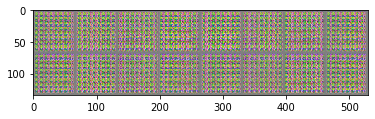

(epoch 2/50)	Loss_D: 0.0155	Loss_G: 7.4985 p_real: 0.150295, p_g: 0.396495


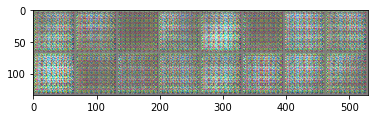

(epoch 3/50)	Loss_D: 0.0573	Loss_G: 6.0736 p_real: 0.707444, p_g: 0.098075


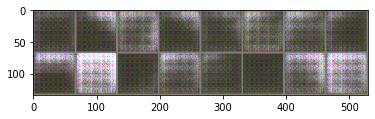

(epoch 4/50)	Loss_D: 0.0247	Loss_G: 7.7406 p_real: 0.341908, p_g: 0.133745


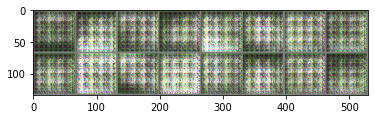

(epoch 5/50)	Loss_D: 0.0274	Loss_G: 10.7392 p_real: 0.923492, p_g: 0.016857


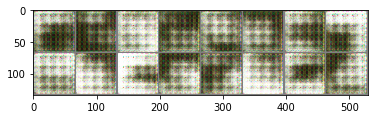

(epoch 6/50)	Loss_D: 0.0051	Loss_G: 9.5529 p_real: 0.606133, p_g: 1.003167


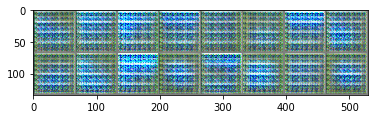

(epoch 7/50)	Loss_D: 0.0130	Loss_G: 8.2074 p_real: 0.286067, p_g: 0.954933


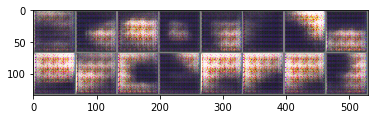

(epoch 8/50)	Loss_D: 0.0074	Loss_G: 9.6001 p_real: 0.633854, p_g: 0.297308


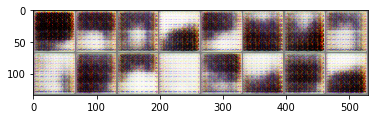

(epoch 9/50)	Loss_D: 0.0147	Loss_G: 9.2350 p_real: 0.748535, p_g: 0.471339


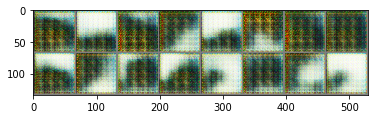

(epoch 10/50)	Loss_D: 0.0099	Loss_G: 9.3359 p_real: 0.952422, p_g: 0.425055


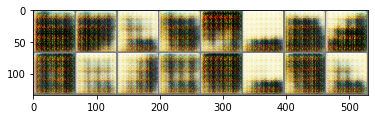

(epoch 11/50)	Loss_D: 0.0183	Loss_G: 8.1013 p_real: 0.675675, p_g: 0.026012


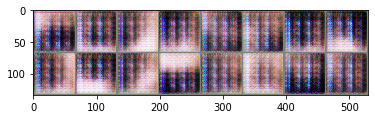

(epoch 12/50)	Loss_D: 0.0047	Loss_G: 8.4830 p_real: 0.870660, p_g: 0.052631


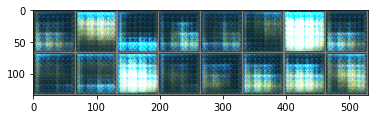

(epoch 13/50)	Loss_D: 0.0267	Loss_G: 10.0456 p_real: 0.891505, p_g: 0.323255


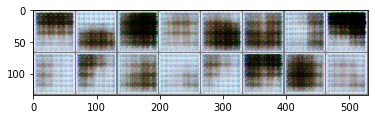

(epoch 14/50)	Loss_D: 0.0022	Loss_G: 9.5698 p_real: 0.604326, p_g: 0.017966


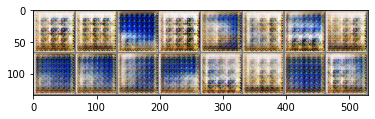

(epoch 15/50)	Loss_D: 0.0143	Loss_G: 8.9065 p_real: 0.490102, p_g: 0.271920


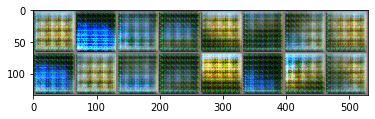

(epoch 16/50)	Loss_D: 0.1314	Loss_G: 6.1401 p_real: 0.881454, p_g: 0.106097


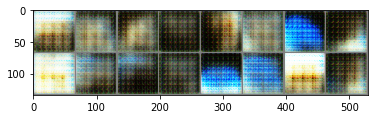

(epoch 17/50)	Loss_D: 0.0146	Loss_G: 7.5117 p_real: 0.954176, p_g: 0.051421


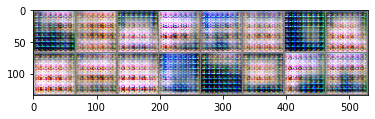

(epoch 18/50)	Loss_D: 0.0104	Loss_G: 8.4136 p_real: 0.604985, p_g: 0.092527


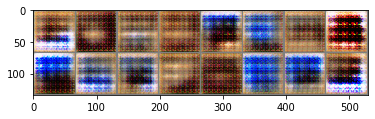

(epoch 19/50)	Loss_D: 0.0314	Loss_G: 7.8984 p_real: 0.807205, p_g: 0.018387


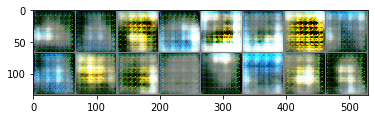

(epoch 20/50)	Loss_D: 0.0304	Loss_G: 8.2602 p_real: 0.867216, p_g: 0.102168


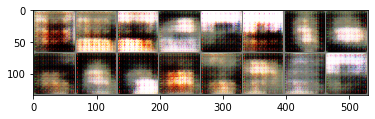

(epoch 21/50)	Loss_D: 0.0216	Loss_G: 8.8506 p_real: 0.852179, p_g: 0.032847


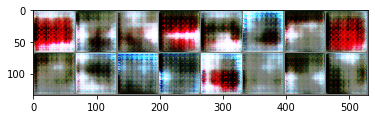

(epoch 22/50)	Loss_D: 0.0425	Loss_G: 7.5946 p_real: 0.299842, p_g: 0.095740


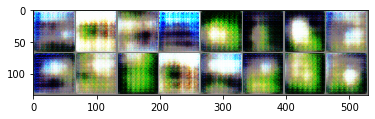

(epoch 23/50)	Loss_D: 0.0516	Loss_G: 8.5919 p_real: 0.908969, p_g: 0.026054


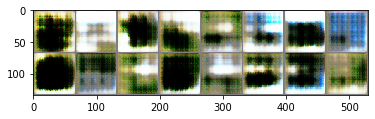

(epoch 24/50)	Loss_D: 0.1353	Loss_G: 4.2118 p_real: 0.939566, p_g: 0.036716


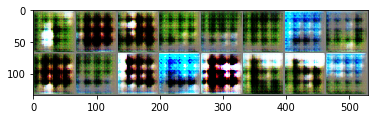

(epoch 25/50)	Loss_D: 0.0459	Loss_G: 5.9766 p_real: 0.603108, p_g: 0.030654


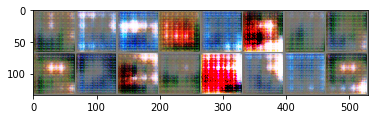

(epoch 26/50)	Loss_D: 0.0119	Loss_G: 7.4041 p_real: 0.751217, p_g: 0.047259


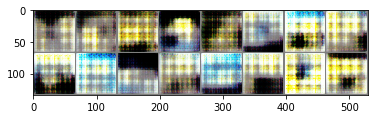

(epoch 27/50)	Loss_D: 0.0130	Loss_G: 10.0579 p_real: 0.717411, p_g: 0.146579


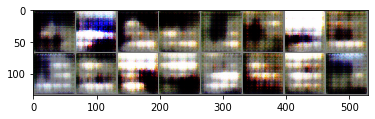

(epoch 28/50)	Loss_D: 0.0662	Loss_G: 6.3552 p_real: 0.415780, p_g: 0.092574


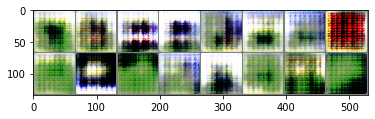

(epoch 29/50)	Loss_D: 0.0322	Loss_G: 6.3793 p_real: 0.723732, p_g: 0.057857


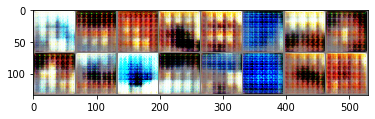

(epoch 30/50)	Loss_D: 0.0109	Loss_G: 7.5349 p_real: 0.372398, p_g: 0.151428


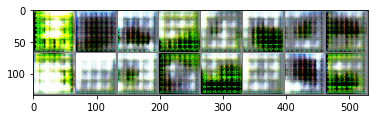

(epoch 31/50)	Loss_D: 0.0172	Loss_G: 7.5524 p_real: 0.392835, p_g: 0.133981


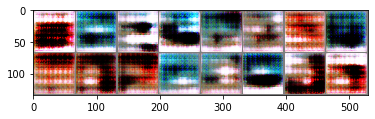

(epoch 32/50)	Loss_D: 0.0165	Loss_G: 7.4216 p_real: 0.419519, p_g: 0.036103


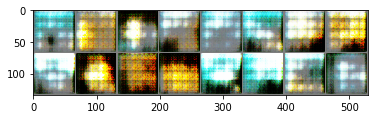

(epoch 33/50)	Loss_D: 0.0033	Loss_G: 10.0861 p_real: 0.698805, p_g: 0.056222


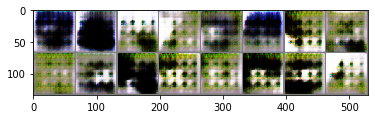

(epoch 34/50)	Loss_D: 0.0114	Loss_G: 8.2491 p_real: 0.807571, p_g: 0.016573


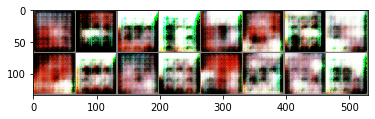

(epoch 35/50)	Loss_D: 0.2840	Loss_G: 15.8043 p_real: 0.397470, p_g: 0.146848


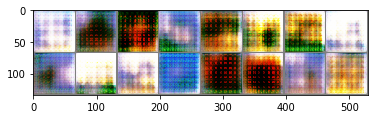

(epoch 36/50)	Loss_D: 0.0180	Loss_G: 6.9289 p_real: 0.645910, p_g: 0.144855


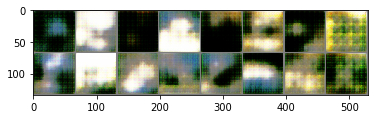

(epoch 37/50)	Loss_D: 0.0179	Loss_G: 6.7979 p_real: 0.727674, p_g: 0.034195


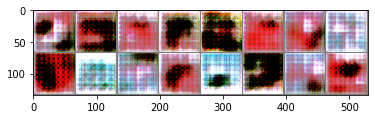

(epoch 38/50)	Loss_D: 0.0397	Loss_G: 5.8259 p_real: 0.594135, p_g: 0.084239


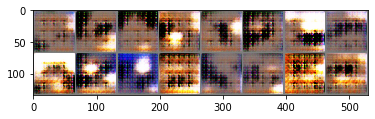

(epoch 39/50)	Loss_D: 0.0233	Loss_G: 6.6264 p_real: 0.333422, p_g: 0.082029


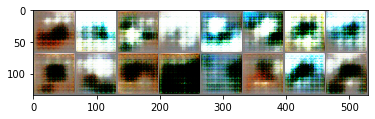

(epoch 40/50)	Loss_D: 0.0459	Loss_G: 6.3076 p_real: 0.585292, p_g: 0.122645


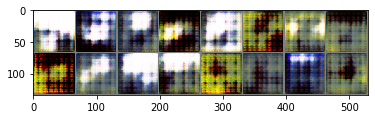

(epoch 41/50)	Loss_D: 0.0287	Loss_G: 7.3876 p_real: 0.573765, p_g: 0.060631


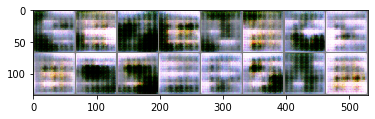

(epoch 42/50)	Loss_D: 0.0775	Loss_G: 6.7859 p_real: 0.388830, p_g: 0.080099


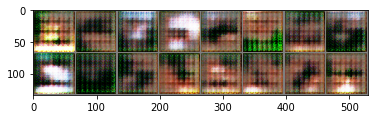

(epoch 43/50)	Loss_D: 0.1059	Loss_G: 7.8629 p_real: 0.684205, p_g: 0.086924


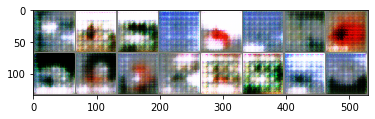

(epoch 44/50)	Loss_D: 0.0240	Loss_G: 7.3681 p_real: 0.649929, p_g: 0.060793


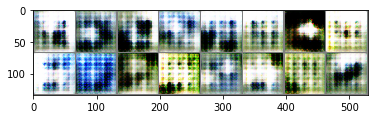

(epoch 45/50)	Loss_D: 0.0192	Loss_G: 11.2426 p_real: 0.508950, p_g: 0.013899


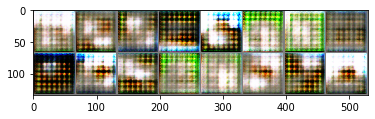

(epoch 46/50)	Loss_D: 0.0254	Loss_G: 9.6105 p_real: 0.419908, p_g: 0.082211


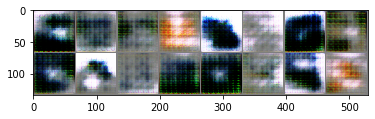

(epoch 47/50)	Loss_D: 0.0022	Loss_G: 10.2020 p_real: 0.271741, p_g: 0.009509


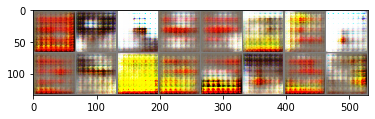

(epoch 48/50)	Loss_D: 0.0148	Loss_G: 7.5311 p_real: 0.517771, p_g: 0.071952


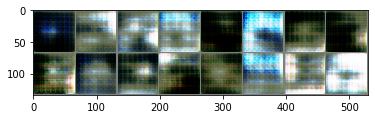

(epoch 49/50)	Loss_D: 0.0532	Loss_G: 6.9938 p_real: 0.386590, p_g: 0.074539


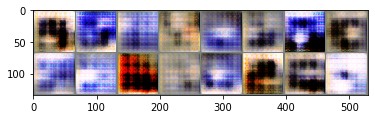

(epoch 50/50)	Loss_D: 0.0184	Loss_G: 8.0835 p_real: 0.880482, p_g: 0.010014


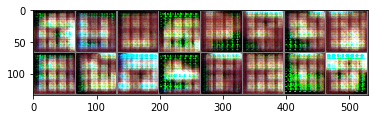

(epoch 51/50)	Loss_D: 0.0188	Loss_G: 10.0554 p_real: 0.198029, p_g: 0.105158


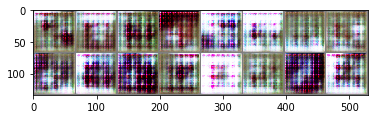

(epoch 52/50)	Loss_D: 0.0117	Loss_G: 7.2202 p_real: 0.485052, p_g: 0.068562


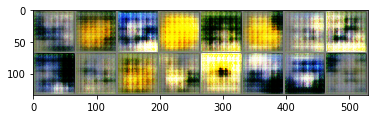

(epoch 53/50)	Loss_D: 0.0241	Loss_G: 10.0998 p_real: 0.480222, p_g: 0.047298


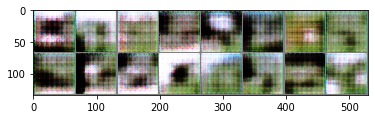

(epoch 54/50)	Loss_D: 0.0856	Loss_G: 7.0746 p_real: 0.768573, p_g: 0.076860


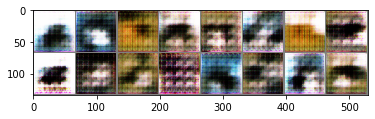

(epoch 55/50)	Loss_D: 0.0394	Loss_G: 5.7949 p_real: 0.763852, p_g: 0.116429


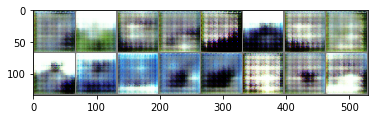

(epoch 56/50)	Loss_D: 0.0189	Loss_G: 9.9624 p_real: 0.659630, p_g: 0.056956


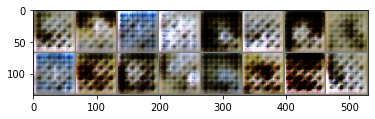

(epoch 57/50)	Loss_D: 0.0222	Loss_G: 6.0375 p_real: 0.576024, p_g: 0.043453


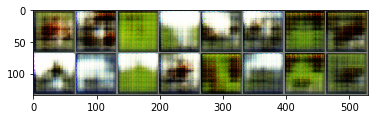

(epoch 58/50)	Loss_D: 0.2837	Loss_G: 6.9667 p_real: 0.740029, p_g: 0.189764


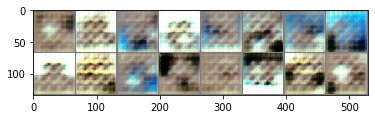

(epoch 59/50)	Loss_D: 0.0351	Loss_G: 7.7383 p_real: 0.504535, p_g: 0.144013


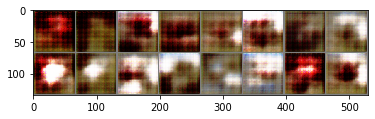

(epoch 60/50)	Loss_D: 0.0157	Loss_G: 7.3260 p_real: 0.890392, p_g: 0.032956


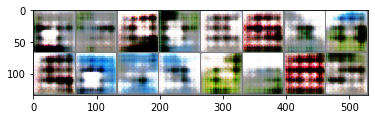

(epoch 61/50)	Loss_D: 0.0694	Loss_G: 7.5587 p_real: 0.797432, p_g: 0.016579


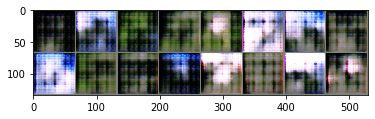

KeyboardInterrupt: ignored

In [11]:
p_real_trace = list()
p_fake_trace = list()
D_losses = list()
G_losses = list()

for epoch in range(num_epochs):
    D_loss, G_loss = train(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G, D)

    p_real_trace.append(p_real) # evaluate 과정이며, 훈련이 된 GAN 모델을 이용해서 진짜 이미지일 확률 분포 값을 의미.
    p_fake_trace.append(p_fake) # evaluate 과정이며, 훈련이 된 GAN 모델을 이용해서 가짜 이미지일 확률 분포 값을 의미.
    D_losses.append(D_loss)
    G_losses.append(G_loss)

    print('(epoch %i/50)\tLoss_D: %.4f\tLoss_G: %.4f p_real: %f, p_g: %f' % (epoch+1, D_loss.item(), G_loss.item(), p_real, p_fake))
    imshow_grid(G(latent_z(16)))

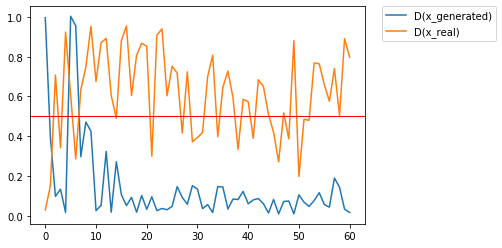

In [12]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.axhline(y=0.5, color='r', linewidth=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

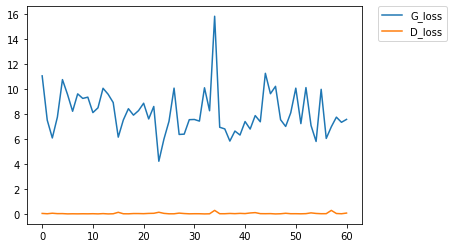

In [13]:
plt.plot(G_losses, label='G_loss')
plt.plot(D_losses, label='D_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

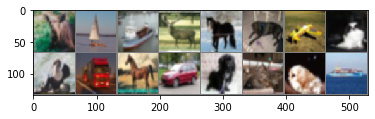

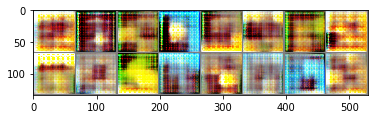

In [14]:
vis_loader = torch.utils.data.DataLoader(test_dataset, 16, True)
img_vis, label_vis   = next(iter(vis_loader))
imshow_grid(img_vis)

imshow_grid(G(latent_z(16,100)).view(-1, nc, 64, 64))